# **Import Library dan Dataset dari Drive**

In [ ]:
from tensorflow.keras import layers
from google.colab import drive
from tensorflow import keras
from zipfile import ZipFile

import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import zipfile,os
import re

drive.mount('/content/drive')

Mounted at /content/drive


# **Data Loading**

Dataset dapat diunduh pada website Kaggle dengan link berikut ini : https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database

In [ ]:
# melakukan ekstraksi pada file dataset
local_zip = '/content/drive/MyDrive/anime_dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Terdapat 2 file utama dalam dataset tersebut dalam format CSV. Pertama yakni anime.csv yang berisi informasi tentang anime yang berasal dari https://myanimelist.net/. Kemudian rating.csv merupakan rating yang diberikan user kepada anime yang ditonton olehnya.

In [ ]:
# mengambil dataset
anime = pd.read_csv("/tmp/anime.csv")
rating = pd.read_csv("/tmp/rating.csv")

# **Data Understanding and EDA**

### **anime.csv**

In [ ]:
anime.info()

anime.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
5,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351
6,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855
7,820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,110,9.11,80679
8,15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534
9,15417,Gintama&#039;: Enchousen,"Action, Comedy, Historical, Parody, Samurai, S...",TV,13,9.11,81109


Terdapat 12.294 sampel atau judul anime dalam dataset tersebut dengan 7 kolom atau fitur. Komposisinya yakni 3 fitur numerik dan 4 fitur kategorikal. Pada fitur rating, nilai diperoleh berdasarkan hasil rata rata dari keseluruhan user yang menilai anime tersebut dengan maksimal nilai yaitu 10. Genre sebuah anime tidak terbatas pada 1 genre saja sehingga terdapat anime yang memiliki banyak genre bahkan hingga lebih dari 5. Terdapat juga type yang merupakan saluran tayang dari anime tersebut.

In [ ]:
anime.describe()

,anime_id,rating,members
count,12294.000000,12064.000000,1.229400e+04
mean,14058.221653,6.473902,1.807134e+04
std,11455.294701,1.026746,5.482068e+04
min,1.000000,1.670000,5.000000e+00
25%,3484.250000,5.880000,2.250000e+02
50%,10260.500000,6.570000,1.550000e+03
75%,24794.500000,7.180000,9.437000e+03
max,34527.000000,10.000000,1.013917e+06


Rating yang diberikan dimulai dari 1 yang terkecil hingga maksimal yaitu 10.

In [ ]:
print('Banyak jenis genre : ', len(anime.genre.unique()))
print('Jeni-jenis genre : ', anime.genre.unique())

Banyak jenis genre :  3265
Jeni-jenis genre :  ['Drama, Romance, School, Supernatural'
 'Action, Adventure, Drama, Fantasy, Magic, Military, Shounen'
 'Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen' ...
 'Hentai, Sports' 'Drama, Romance, School, Yuri' 'Hentai, Slice of Life']


Bisa dilihat terdapat banyak sekali genre dalam dataset tersebut. Hal itu dikarenakan genre tersebut tidak ditampilkan secara terpisah, sehingga sering terjadinya pengulangan genre pada jenis anime yang memiliki lebih dari 1 genre. Contoh pada anime Kimi No Nawa dengan 4 genre. Pada tahapan pemrosesan data nantinya genre akan dipisahkan.

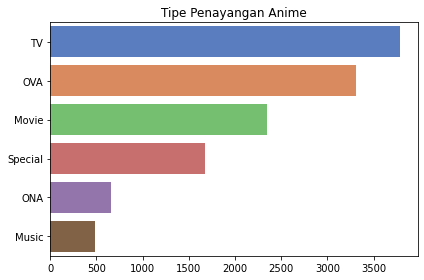

In [ ]:
type_count = anime['type'].value_counts()

sns.barplot(x=type_count.values,
            y=type_count.index,
            palette='muted').set_title('Tipe Penayangan Anime')

plt.tight_layout()
plt.show()

Tipe penayangan anime terbesar dipegang oleh TV dengan lebih dari 3000 judul anime kemudian diikuti oleh OVA dan Movie.

### **rating.csv**

In [ ]:
rating.info()
rating

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


Pada dataset rating, jumlah sampel berukuran cukup besar yakni sekitar 7 juta sampel. Hal itu dikarenakan terdapat rating -1 yang merupakan tanda bahwa user sudah menonton anime tersebut namun tidak memberikan rating. User yang sudah menonton dapat memberikan rating dari 1-10 atau tidak memberikan rating.

In [ ]:
print('Jumlah user : ', len(rating.user_id.unique()))
print('Jumlah anime yang diberi rating oleh user : ', (rating['rating'] != -1).sum())

Jumlah user :  73515
Jumlah anime yang diberi rating oleh user :  6337241


In [ ]:
rating.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

Setelah dicek, ternyata hanya terdapat 73 ribu user unik dalam 7 juta sampel tersebut. Kemudian juga jumlah rating hanya terdapat kurang lebih 6 juta saja sehingga dapat dikatakan terdapat 1 juta lebih user yang tidak memberikan rating pada anime yang sudah ditontonnya.

# **Data Preprocessing**

Bisa dilihat sebelumnya pada dataset anime.csv bahwa banyak sekali kesalahan penulisan atau simbol simbol tidak penting pada fitur name. Kemudian juga pada fitur genre terdapat tanda koma untuk memisahkan setiap genre. Hal tersebut dapat menyebabkan error pada saat kita memprosesnya dikarenakan dalam beberapa proses, tanda koma bisa dianggap sebagai tipe numerik atau float. 

Oleh karena itu perlu dilakukan data cleaning terlebih dahulu

In [ ]:
def name_cleaning(text):
    text = re.sub(r'&quot;', '', text)
    text = re.sub(r'&quot;', '', text)
    text = re.sub(r'.hack//', '', text)
    text = re.sub(r'&#039;', '', text)
    text = re.sub(r'A&#039;s', '', text)
    text = re.sub(r'I&#039;', 'I\'', text)
    text = re.sub(r'&amp;', 'and', text)
    text = re.sub(r'°', 'and', text)
    return text

def genre_cleaning(text):
    text = re.sub(r",","", str(text))
    return text

anime['name'] = anime['name'].apply(name_cleaning)
anime['genre'] = anime['genre'].apply(genre_cleaning)

anime.info()
anime.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12294 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,Drama Romance School Supernatural,Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,Action Adventure Drama Fantasy Magic Military ...,TV,64,9.26,793665
2,28977,Gintamaand,Action Comedy Historical Parody Samurai Sci-Fi...,TV,51,9.25,114262
3,9253,Steins;Gate,Sci-Fi Thriller,TV,24,9.17,673572
4,9969,Gintama,Action Comedy Historical Parody Samurai Sci-Fi...,TV,51,9.16,151266


Bisa dilihat pada hasil diatas, pada fitur name sudah tidak terdapat simbol atau angka yang mengganggu kemudian pada fitur genre sudah tidak terdapat koma sebagai pemisah antar genre.

Berikutnya yakni menggabungkan kedua dataset tersebut, karena terdapat kesamaan nama pada fitur rating kedua dataset, maka fitur rating pada dataset kedua kita ubah namanya menjadi rating_user agar tampak berbeda.

In [ ]:
# menggabungkan 2 dataset menjadi 1 berdasarkan anime id dan mengurutkannya
df = pd.merge(anime,rating,on='anime_id',suffixes= ['', '_user'])
df = df.sort_values('user_id', ascending=True)

# menghapus rating -1 karena tidak relevan
df.drop(df[df['rating_user'] == -1].index, inplace = True)

# cek dan hapus nilai null
df = df.dropna()
df.isnull().sum()

anime_id       0
name           0
genre          0
type           0
episodes       0
rating         0
members        0
user_id        0
rating_user    0
dtype: int64

Kemudian pada fitur rating user, terdapat nilai -1 yang menandakan bahwa user tersebut belum memberi rating pada animenya. Informasi tersebut tidak kita perlukan saat ini, sehingga lebih baik kita hapus saja.

Setelah dilihat, saya rasa kita tidak memerlukan fitur type, episode dan members saat ini. Oleh karena itu lebih baik kita drop saja agar mempercepat proses nantinya.

In [ ]:
df.drop(['type', 'members','episodes'], axis=1)
df

,anime_id,name,genre,type,episodes,rating,members,user_id,rating_user
2927023,15451,High School DxD New,Action Comedy Demons Ecchi Harem Romance School,TV,12,7.87,266657,1,10
3778893,11617,High School DxD,Comedy Demons Ecchi Harem Romance School,TV,12,7.70,398660,1,10
4941924,8074,Highschool of the Dead,Action Ecchi Horror Supernatural,TV,12,7.46,535892,1,10
3160072,11757,Sword Art Online,Action Adventure Fantasy Game Romance,TV,25,7.83,893100,1,10
803381,11771,Kuroko no Basket,Comedy School Shounen Sports,TV,25,8.46,338315,2,10
...,...,...,...,...,...,...,...,...,...
4430945,5355,Sengoku Basara,Action Historical Martial Arts Samurai Super P...,TV,12,7.57,93940,73515,10
2397822,3782,Kara no Kyoukai 2: Satsujin Kousatsu (Zen),Action Mystery Romance Supernatural Thriller,Movie,1,8.02,114415,73515,10
1487004,2025,Darker than Black: Kuro no Keiyakusha,Action Mystery Sci-Fi Super Power,TV,25,8.25,440334,73515,10
4964988,8074,Highschool of the Dead,Action Ecchi Horror Supernatural,TV,12,7.46,535892,73516,9


# **Data Preparation**

In [ ]:
# dataset yang akan dipakai
df

,anime_id,name,genre,type,episodes,rating,members,user_id,rating_user
2927023,15451,High School DxD New,Action Comedy Demons Ecchi Harem Romance School,TV,12,7.87,266657,1,10
3778893,11617,High School DxD,Comedy Demons Ecchi Harem Romance School,TV,12,7.70,398660,1,10
4941924,8074,Highschool of the Dead,Action Ecchi Horror Supernatural,TV,12,7.46,535892,1,10
3160072,11757,Sword Art Online,Action Adventure Fantasy Game Romance,TV,25,7.83,893100,1,10
803381,11771,Kuroko no Basket,Comedy School Shounen Sports,TV,25,8.46,338315,2,10
...,...,...,...,...,...,...,...,...,...
4430945,5355,Sengoku Basara,Action Historical Martial Arts Samurai Super P...,TV,12,7.57,93940,73515,10
2397822,3782,Kara no Kyoukai 2: Satsujin Kousatsu (Zen),Action Mystery Romance Supernatural Thriller,Movie,1,8.02,114415,73515,10
1487004,2025,Darker than Black: Kuro no Keiyakusha,Action Mystery Sci-Fi Super Power,TV,25,8.25,440334,73515,10
4964988,8074,Highschool of the Dead,Action Ecchi Horror Supernatural,TV,12,7.46,535892,73516,9


In [ ]:
# menampilkan genre secara unik
df.genre.unique()

array(['Action Comedy Demons Ecchi Harem Romance School',
       'Comedy Demons Ecchi Harem Romance School',
       'Action Ecchi Horror Supernatural', ...,
       'Adventure Shoujo Slice of Life',
       'Action Adventure Kids Mecha Sci-Fi Space',
       'Action Historical Kids'], dtype=object)

Genre anime bisa lebih dari 1 oleh karena itu terdapat cukup banyak genre karena kondisi masih belum dipisah.

In [ ]:
# mengurutkan data berdasarkan anime id
df.sort_values('anime_id')

# menghapus duplikat untuk proses training model
preparation = df.drop_duplicates('anime_id')
preparation

,anime_id,name,genre,type,episodes,rating,members,user_id,rating_user
2927023,15451,High School DxD New,Action Comedy Demons Ecchi Harem Romance School,TV,12,7.87,266657,1,10
3778893,11617,High School DxD,Comedy Demons Ecchi Harem Romance School,TV,12,7.70,398660,1,10
4941924,8074,Highschool of the Dead,Action Ecchi Horror Supernatural,TV,12,7.46,535892,1,10
3160072,11757,Sword Art Online,Action Adventure Fantasy Game Romance,TV,25,7.83,893100,1,10
803381,11771,Kuroko no Basket,Comedy School Shounen Sports,TV,25,8.46,338315,2,10
...,...,...,...,...,...,...,...,...,...
7686696,33659,Fushigi na Somera-chan Special,Comedy Magic Slice of Life,Special,1,5.15,444,69964,6
7686922,23585,Haha wo Tazunete Sanzenri Specials,Adventure Drama Slice of Life,Special,2,6.14,138,69964,7
7686730,30738,Gamba: Gamba to Nakama-tachi,Adventure Kids,Movie,1,5.55,185,72800,4
7686130,8723,Anime Rakugo Kan,Comedy,OVA,4,5.84,264,73135,5


Saat proses pelatihan model, data duplikat tidak diperlukan dalam pemrosesan. Oleh karena itu lebih baik dihapus saja. Selanjutnya kita akan mengubah data dalam bentuk list agar dengan ukuran yang sama agar dapat dijadikan dictionary

In [ ]:
# Mengonversi data series anime id menjadi dalam bentuk list
anime_id = preparation['anime_id'].tolist()
 
# Mengonversi data series name menjadi dalam bentuk list
anime_name = preparation['name'].tolist()
 
# Mengonversi data series genre menjadi dalam bentuk list
anime_genre = preparation['genre'].tolist()
 
print(len(anime_id))
print(len(anime_name))
print(len(anime_genre))

9924
9924
9924


In [ ]:
# Membuat dictionary
dataset_new = pd.DataFrame({
    'id': anime_id,
    'name': anime_name,
    'genre': anime_genre
})

dataset_new

,id,name,genre
0,15451,High School DxD New,Action Comedy Demons Ecchi Harem Romance School
1,11617,High School DxD,Comedy Demons Ecchi Harem Romance School
2,8074,Highschool of the Dead,Action Ecchi Horror Supernatural
3,11757,Sword Art Online,Action Adventure Fantasy Game Romance
4,11771,Kuroko no Basket,Comedy School Shounen Sports
...,...,...,...
9919,33659,Fushigi na Somera-chan Special,Comedy Magic Slice of Life
9920,23585,Haha wo Tazunete Sanzenri Specials,Adventure Drama Slice of Life
9921,30738,Gamba: Gamba to Nakama-tachi,Adventure Kids
9922,8723,Anime Rakugo Kan,Comedy


Setelah melewati berbagai tahapan, dataset dengan 3 fitur diatas siap digunakan dalam pemodelan.

# **Model Development**

## **Content Based Filtering**

Pada tahapan ini akan dikembangkan model dengan content based filtering atau dengan singkatnya yakni rekomendasi berdasarkan kesesuaian fiturnya. Kesesuaian yang digunakan disini adalah genre dari anime tersebut. Seperti yang diketahui genre merupakan identitas sebuah anime yang penting diperhatikan.

In [ ]:
data = dataset_new

data.sample(5)

,id,name,genre
4309,2757,Juuni Senshi Bakuretsu Eto Ranger,Action Comedy Fantasy
7880,1708,Majuu Sensen: The Apocalypse,Action Fantasy
5350,1248,Zone of the Enders: Idolo,Action Drama Mecha Military Romance Sci-Fi Space
2526,2015,Wind: A Breath of Heart,Comedy School
9830,6156,Xi Yang Yang Yu Hui Tai Lang: Zhi Niu Qi Chong...,Adventure Comedy Kids


### **TF-IDF Vectorizer**

Berikutnya yakni tahapan TF IDF, tahapan ini sangat penting dalam content based filtering. Hal tersebut dikarenakan pada tahap inilah kita bisa melihat representasi fitur penting dari genre anime yang akan kita olah.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
 
# Inisialisasi TfidfVectorizer
tf = TfidfVectorizer()
 
# Melakukan perhitungan idf pada data genre
tf.fit(data['genre']) 
 
# Mapping array dari fitur index integer ke fitur nama
tf.get_feature_names() 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['action',
 'adventure',
 'ai',
 'arts',
 'cars',
 'comedy',
 'dementia',
 'demons',
 'drama',
 'ecchi',
 'fantasy',
 'fi',
 'game',
 'harem',
 'hentai',
 'historical',
 'horror',
 'josei',
 'kids',
 'life',
 'magic',
 'martial',
 'mecha',
 'military',
 'music',
 'mystery',
 'nan',
 'of',
 'parody',
 'police',
 'power',
 'psychological',
 'romance',
 'samurai',
 'school',
 'sci',
 'seinen',
 'shoujo',
 'shounen',
 'slice',
 'space',
 'sports',
 'super',
 'supernatural',
 'thriller',
 'vampire',
 'yaoi',
 'yuri']

In [ ]:
# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = tf.fit_transform(data['genre']) 
 
# Melihat ukuran matrix tfidf
tfidf_matrix.shape

(9924, 48)

Bisa dilihat dari hasil tf idf, terdapat 48 genre dari 9924 sampel. Di tahapan sebelumnya, genre unik dalam sampel berjumlah 3000 namun setelah dilakukan mapping tf idf hanya terdeteksi 48 genre saja. Berikutnya yakni mengubahnya dalam bentuk matriks

In [ ]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0.25811167, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.33250652, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.5960681 , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [ ]:
# Membuat dataframe untuk melihat tf-idf matrix
# Kolom diisi dengan genre anime
# Baris diisi dengan nama anime
 
pd.DataFrame(
    tfidf_matrix.todense(), 
    columns=tf.get_feature_names(),
    index=data.name
).sample(22, axis=1).sample(10, axis=0)

,thriller,adventure,shoujo,fantasy,cars,power,life,horror,demons,music,...,historical,space,slice,military,parody,mecha,ecchi,supernatural,dementia,romance
name,,,,,,,,,,,,,,,,,,,,,
Inaka Isha,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.458605,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.589759,0.000000
12-sai. 2nd Season,0.0,0.000000,0.657658,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.511178
Kara no Kyoukai: Shuushou,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
Kaiketsu Jouki Tanteidan,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.000000,0.000000,0.00000,0.000000,0.0,0.446302,0.000000,0.000000,0.000000,0.000000
Kino no Tabi: The Beautiful World - Tou no Kuni,0.0,0.428854,0.000000,0.438085,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
Hyouka: Motsubeki Mono wa,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.57735,0.0,0.0,0.0,...,0.000000,0.000000,0.57735,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
Taimadou Gakuen 35 Shiken Shoutai,0.0,0.000000,0.000000,0.289792,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.000000,0.000000,0.00000,0.456237,0.0,0.000000,0.411363,0.365032,0.000000,0.321989
Ryokunohara Meikyuu,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.489226,0.293987
Tenshi Nanka ja Nai,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


### **Cosine Similarity**

Pada tahapan berikutnya akan dicari cosine similarity antara anime dengan genrenya. Tujuannya agar kita dapat menemukan kesamaan diantara berbagai anime berdasarkan genre mereka. Kesamaan tersebut diubah dalam bentuk numerik dan disusun menjadi matriks.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
 
# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix) 
cosine_sim

array([[1.        , 0.96611509, 0.30575287, ..., 0.        , 0.21373739,
        0.21373739],
       [0.96611509, 1.        , 0.22764271, ..., 0.        , 0.22123388,
        0.22123388],
       [0.30575287, 0.22764271, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.21373739, 0.22123388, 0.        , ..., 0.        , 1.        ,
        1.        ],
       [0.21373739, 0.22123388, 0.        , ..., 0.        , 1.        ,
        1.        ]])

In [ ]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa nama
cosine_sim_df = pd.DataFrame(cosine_sim, index=data['name'], columns=data['name'])
print('Shape:', cosine_sim_df.shape)
 
# Melihat similarity matrix pada setiap anime
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (9924, 9924)


name,Galactic Patrol Lensman,Robot Girls Z,Astarotte no Omocha! EX,Aa! Megami-sama!: Sorezore no Tsubasa,Sora no Otoshimono: Tokeijikake no Angeloid
name,,,,,
Tenjou-jin to Akuto-jin Saigo no Tatakai,0.127595,0.000000,0.099042,0.397279,0.141431
Yakin Byoutou San,0.000000,0.000000,0.000000,0.000000,0.000000
Karigurashi no Arrietty,0.000000,0.000000,0.315822,0.000000,0.000000
Tsukuyomi: Moon Phase Special,0.000000,0.083244,0.058156,0.067207,0.052339
Comet Lucifer: Garden Indigo no Shasou kara,0.313764,0.154240,0.307598,0.124526,0.096978
Hunter x Hunter: Greed Island,0.323850,0.000000,0.000000,0.000000,0.113650
Arcana Famiglia: Capriccio - stile Arcana Famiglia,0.000000,0.000000,0.215350,0.248868,0.193812
Kuma ni Kuwarenu Otoko,0.297124,0.000000,0.000000,0.000000,0.000000
Koi Tsubomi,0.000000,0.000000,0.187844,0.000000,0.000000


Bisa dilihat pada gambar diatas, kita dapat melihat kesamaan antar berbagai anime dengan skor numerik mereka mulai dari 0 hingga 1. Kemudian berikutnya kita tinggal membuat fungsi untuk memprediksinya saja.

In [ ]:
def anime_recommendations(nama_anime, similarity_data=cosine_sim_df, items=data[['name', 'genre']], k=10): 
    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan    
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,nama_anime].to_numpy().argpartition(
        range(-1, -k, -1))
    
    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    
    # Drop nama anime agar nama anime yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(nama_anime, errors='ignore')

    result = pd.DataFrame(closest).merge(items).head(k)

    return result

Berikutnya tinggal memanggil fungsinya dengan menginputkan judul anime yang sudah pernah ditonton

In [ ]:
# input judul
input = 'Sword Art Online'

rec = data[data.name.eq(input)]
rec

,id,name,genre
3,11757,Sword Art Online,Action Adventure Fantasy Game Romance


In [ ]:
# hasil rekomendasi
hasil = anime_recommendations(input)
hasil

,name,genre
0,Sword Art Online: Extra Edition,Action Adventure Fantasy Game Romance
1,Sword Art Online II,Action Adventure Fantasy Game Romance
2,Sword Art Online II: Debriefing,Action Adventure Fantasy Game
3,Ys IV: The Dawn of Ys,Action Adventure Fantasy Game
4,"Slime Boukenki: Umi da, Yeah!",Action Adventure Comedy Fantasy Game
5,Bakugan Battle Brawlers: Gundalian Invaders,Action Adventure Fantasy Game Shounen
6,Bakugan Battle Brawlers: Mechtanium Surge,Action Adventure Fantasy Game Shounen
7,Monster Strike: Mermaid Rhapsody,Action Fantasy Game
8,Monster Strike,Action Fantasy Game
9,Log Horizon 2nd Season,Action Adventure Fantasy Game Magic Shounen


### **Metrik Evaluasi**

Setelah berhasil membuat rekomendasi anime, berikutnya yakni mengevaluasi hasil metrik dengan teknik metrik precision. Dalam metrik precision kasus ini, nilai akan diambil berdasarkan genre yang sesuai dengan input user. 

Nilai setiap genre yang sesuai dengan input akan dibagi dengan keseluruhan genre hasil rekomendasi. Contoh pada rekomendasi pertama nilai yang diperoleh adalah 1 dari hasil bagi 5 benar dan 5 total genre. Kemudian pada rekomendasi terakhir hanya 4 genre yang sesuai maka hasilnya adalah 4 / 6 yakni 0.6.

Dari seluruh hasil presisi rekomendasi tersebut, diakhir nanti akan dicari rata-ratanya. Hasil rata rata tersebutlah yang merupakan metrik presisi pada kasus ini

In [ ]:
# membuat list dari genre input untuk dibandingkan
x = rec['genre'].tolist()
y = x[0].split()

loop_skor = 0

# perulangan untuk membandingkan genre input dan hasil
for i in range (e):

  q = len(y)
  e = len(hasil)

  temp_skor = 0
  skor = 0

  # membuat list dari genre hasil untuk dibandingkan
  a = hasil._get_value(i, 'genre')
  b = a.split()

  if len(b) < q:
    q = len(b)

  for j in range (q):

    if y[j] == b[j]:
      skor += 1

  temp_skor = skor / len(b)
  loop_skor += temp_skor

# hasil jumlah keseluruhan dibagi total
result = loop_skor/e

print("Skor Presisi Akhir : ", result)

Skor Presisi Akhir :  0.7333333333333333


## **Collaborative Filtering**

Berbeda dengan content based, pada collaborative filtering ini rekomendasi yang diberikan adalah sesuai dengan komunitas pengguna terkait. Sehingga faktor pengguna lain atau rating berperan besar disini.

### **Data Preparation**

In [ ]:
df = rating

#menghapus rating -1 kembali
df.drop(df[df['rating'] == -1].index, inplace = True)

# menghapus data agar tersisa 50 ribu
df.drop(df.index[50000:6337241], inplace=True)

df

,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
83,1,11757,10
101,1,15451,10
153,2,11771,10
...,...,...,...
62842,656,11981,9
62843,656,12079,7
62844,656,12189,8
62845,656,12355,10


Pada collaborative filtering disini hanya akan digunakan 50 ribu data saja dari 6 juta data yang ada. Hal itu bertujuan agar saat proses training epoch dapat berjalan lebih cepat. Namun jika ingin mengubahnya dapat ditingkatkan lagi tapi harus ingat dengan spesifikasi komputer

Berikutnya kita akan masuk ke tahap data preprocessing lagi yang bertujuan untuk encode fitur user id dan anime id

In [ ]:
# Mengubah user id menjadi list tanpa nilai yang sama
user_ids = df['user_id'].unique().tolist()
 
# Melakukan encoding user id
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}

# Melakukan proses encoding angka ke ke user id
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}

In [ ]:
# Mengubah anime id menjadi list tanpa nilai yang sama
anime_ids = df['anime_id'].unique().tolist()
 
# Melakukan proses encoding anime id
anime_to_anime_encoded = {x: i for i, x in enumerate(anime_ids)}
 
# Melakukan proses encoding angka ke anime id
anime_encoded_to_anime = {i: x for i, x in enumerate(anime_ids)}

In [ ]:
# Mapping user id ke dataframe user
df['user'] = df['user_id'].map(user_to_user_encoded)
 
# Mapping anime id ke dataframe anime
df['anime'] = df['anime_id'].map(anime_to_anime_encoded)

In [ ]:
# Mendapatkan jumlah user
num_users = len(user_to_user_encoded)
print(num_users)
 
# Mendapatkan jumlah anime
num_anime = len(anime_encoded_to_anime)
print(num_anime)
 
# Mengubah rating menjadi nilai float
df['rating'] = df['rating'].values.astype(np.float32)
 
# Nilai minimum rating
min_rating = min(df['rating'])
 
# Nilai maksimal rating
max_rating = max(df['rating'])
 
print('Number of User: {}, Number of Anime: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_anime, min_rating, max_rating
))

617
4040
Number of User: 617, Number of Anime: 4040, Min Rating: 1.0, Max Rating: 10.0


Bisa dilihat informasi jumlah user, anime beserta rating min maxnya.

In [ ]:
# Mengacak dataset
df = df.sample(frac=1, random_state=42)
df

,user_id,anime_id,rating,user,anime
43589,462,15583,8.0,434,381
11944,152,23225,6.0,143,978
405,5,1764,6.0,3,25
16098,202,264,8.0,191,131
50537,531,20787,7.0,496,449
...,...,...,...,...,...
13909,177,31442,6.0,167,691
56392,581,9736,9.0,543,1848
48960,514,18893,9.0,479,617
1110,7,30365,7.0,4,677


Berikutnya yakni membagi dataset menjadi 80% data training dan 20% data testing

### **Train Test Split**

In [ ]:
# Membuat variabel x untuk mencocokkan data user dan anime menjadi satu value
x = df[['user', 'anime']].values
 
# Membuat variabel y untuk membuat rating dari hasil 
y = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
 
# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)
 
print(x, y)

[[ 434  381]
 [ 143  978]
 [   3   25]
 ...
 [ 479  617]
 [   4  677]
 [ 231 1339]] [0.77777778 0.55555556 0.55555556 ... 0.88888889 0.66666667 0.77777778]


### **Training**

Kemudian masuk ke tahapan utama yakni training, pada model kali ini digunakan teknik embedding untuk menghitung nilai kecocokan user dengan anime yang dicari. Pembangunan model menggunakan keras model class

In [ ]:
class RecommenderNet(tf.keras.Model):
 
  # Insialisasi fungsi
  def __init__(self, num_users, num_anime, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_anime = num_anime
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( 
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) 
    self.anime_embedding = layers.Embedding( 
        num_anime,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.anime_bias = layers.Embedding(num_anime, 1) 
 
  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) 
    user_bias = self.user_bias(inputs[:, 0]) 
    anime_vector = self.anime_embedding(inputs[:, 1])
    anime_bias = self.anime_bias(inputs[:, 1])
 
    dot_user_anime = tf.tensordot(user_vector, anime_vector, 2) 
 
    x = dot_user_anime + user_bias + anime_bias
    
    return tf.nn.sigmoid(x) # activation sigmoid

In [ ]:
model = RecommenderNet(num_users, num_anime, 50) # inisialisasi model
 
# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [ ]:
# Memulai training

history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 50,
    validation_data = (x_val, y_val)
)

Epoch 1/50
5000/5000 [==============================] - 18s 3ms/step - loss: 0.5730 - root_mean_squared_error: 0.2041 - val_loss: 0.5344 - val_root_mean_squared_error: 0.1559
Epoch 2/50
5000/5000 [==============================] - 16s 3ms/step - loss: 0.5279 - root_mean_squared_error: 0.1487 - val_loss: 0.5273 - val_root_mean_squared_error: 0.1470
Epoch 3/50
5000/5000 [==============================] - 16s 3ms/step - loss: 0.5217 - root_mean_squared_error: 0.1412 - val_loss: 0.5249 - val_root_mean_squared_error: 0.1445
Epoch 4/50
5000/5000 [==============================] - 17s 3ms/step - loss: 0.5188 - root_mean_squared_error: 0.1375 - val_loss: 0.5233 - val_root_mean_squared_error: 0.1428
Epoch 5/50
5000/5000 [==============================] - 18s 4ms/step - loss: 0.5169 - root_mean_squared_error: 0.1351 - val_loss: 0.5233 - val_root_mean_squared_error: 0.1429
Epoch 6/50
5000/5000 [==============================] - 17s 3ms/step - loss: 0.5161 - root_mean_squared_error: 0.1341 - val_l

### **Metrik Evaluasi**

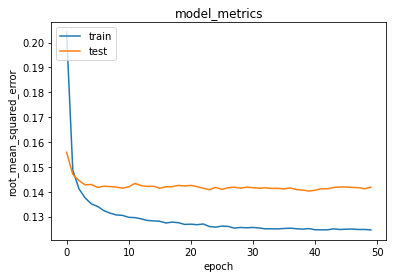

In [ ]:
# ploting hasil training model
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Bisa dilihat dari hasil matriks diatas bisa dilihat pada data training nilai RMSE terus menurun hingga menyentuh dibawah 0.13. Kemudian pada data testing nilai RMSE stabil antara 0.15 dan 0.14. Hal ini merupakan hasil yang baik mengingat sistem rekomendasi yang akurat sangat sulit dibuat

### **Prediksi**

In [ ]:
df1 = pd.read_csv("/tmp/rating.csv")
df1.drop(df1[df1['rating'] == -1].index, inplace = True)
df1.drop(df1.index[50000:6337241], inplace=True)
df1

,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
83,1,11757,10
101,1,15451,10
153,2,11771,10
...,...,...,...
62842,656,11981,9
62843,656,12079,7
62844,656,12189,8
62845,656,12355,10


In [ ]:
anime_df = dataset_new
 
# Mengambil sample user
user_id_ = df.user_id.sample(1).iloc[0]
anime_visited_by_user = df[df.user_id == user_id_]
 
# Operator bitwise (~), bisa diketahui di sini https://docs.python.org/3/reference/expressions.html 
anime_not_visited = anime_df[~anime_df['id'].isin(anime_visited_by_user.anime_id.values)]['id'] 
anime_not_visited = list(
    set(anime_not_visited)
    .intersection(set(anime_to_anime_encoded.keys()))
)
 
anime_not_visited = [[anime_to_anime_encoded.get(x)] for x in anime_not_visited]
user_encoder = user_to_user_encoded.get(user_id_)
user_anime_array = np.hstack(
    ([[user_encoder]] * len(anime_not_visited), anime_not_visited)
)

user_anime_array

array([[ 476, 1031],
       [ 476, 2404],
       [ 476, 1032],
       ...,
       [ 476,  390],
       [ 476, 1693],
       [ 476, 2962]])

In [ ]:
ratings = model.predict(user_anime_array).flatten()
 
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_anime_ids = [
    anime_encoded_to_anime.get(anime_not_visited[x][0]) for x in top_ratings_indices
]
 
print('Showing recommendations for users: {}'.format(user_id_))
print('===' * 9)
print('anime with high ratings from user')
print('----' * 8)
 
top_anime_user = (
    anime_visited_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .anime_id.values
)
 
anime_df_rows = anime_df[anime_df['id'].isin(top_anime_user)]
for row in anime_df_rows.itertuples():
    print(row.name, ':', row.genre)
 
print('----' * 8)
print('Top 10 anime recommendation')
print('----' * 8)
 
recommended_anime = anime_df[anime_df['id'].isin(recommended_anime_ids)]
for row in recommended_anime.itertuples():
    print(row.name, ':', row.genre)

Showing recommendations for users: 511
anime with high ratings from user
--------------------------------
Zero no Tsukaima : Action Adventure Comedy Ecchi Fantasy Harem Magic Romance School
Rosario to Vampire : Comedy Ecchi Fantasy Harem Romance School Shounen Vampire
Code Geass: Hangyaku no Lelouch : Action Mecha Military School Sci-Fi Super Power
Code Geass: Hangyaku no Lelouch R2 : Action Drama Mecha Military Sci-Fi Super Power
Tengen Toppa Gurren Lagann : Action Adventure Comedy Mecha Sci-Fi
--------------------------------
Top 10 anime recommendation
--------------------------------
Gintama Movie: Kanketsu-hen - Yorozuya yo Eien Nare : Action Comedy Historical Parody Samurai Sci-Fi Shounen
Gintama: Enchousen : Action Comedy Historical Parody Samurai Sci-Fi Shounen
Uchuu Kyoudai : Comedy Sci-Fi Seinen Slice of Life Space
Kuroshitsuji: Book of Murder : Comedy Demons Fantasy Historical Mystery Shounen Supernatural
Haikyuu!!: Karasuno Koukou VS Shiratorizawa Gakuen Koukou : Comedy Dra